In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
!unzip mnist.zip

In [2]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

In [3]:
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

In [4]:
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
    Y_train.append( int(train_file.split('/')[3]) )
    X_train.append(np.array(Image.open(train_file)))
    
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
    Y_valid.append( int(valid_file.split('/')[3]) )
    X_valid.append( np.array(Image.open(valid_file)) )
    
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
    Y_test.append( int(test_file.split('/')[3]) )
    X_test.append( np.array(Image.open(test_file)) )

In [5]:
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [6]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
    fig = plt.figure(figsize=(10, 10))
    cm = confusion_matrix(Y_true, Y_pred)
    lclasses = np.arange(0,classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmap=plt.cm.Blues
    ax = fig.add_subplot(1,1,1)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
    ax.set_xlabel("Predicted",size=20)
    ax.set_ylabel("True",size=20)
    ax.set_ylim(classes-0.5, -0.5)

    plt.setp(ax.get_xticklabels(), size=12)
    plt.setp(ax.get_yticklabels(), size=12)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

    plt.show()

In [7]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
    loss_train = []
    f1_train = []
    acc_train = []

    loss_valid = []
    f1_valid = []
    acc_valid = []

    for epoch in range(n_epoch):
        model.train()

        Xtr = X_train.view(X_train.size(0), -1)
        Y_pred = model(Xtr)

        loss = criterion(Y_pred,Y_train)
        loss_train.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
        acc = sum(Y_train == Y_pred)/len(Y_pred)
        acc_train.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        Xvl = X_valid.view(X_valid.size(0), -1)
        Y_pred = model(Xvl)  
        loss = criterion(Y_pred,Y_valid)
        loss_valid.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

        acc = sum(Y_valid == Y_pred)/len(Y_pred)
        acc_valid.append(acc)

    #print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
    #CM(Y_valid, Y_pred, 10)

# Modelo 1

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [256,512,1024]
lr_list = [0.003,0.02,0.1]
wd_list = [0.003,0.02,0.1]
hd_list = [10,40,60]
ne_list = [5,55,105]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
    for bs in bs_list:
        train_ds = TensorDataset(X_train, Y_train)
        train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

        for lr in lr_list:
            for wd in wd_list:
                for hd in hd_list:
                    input_dim = 28*28
                    out_dim = 10
                    hidden = hd

                    model = torch.nn.Sequential(
                        torch.nn.Linear(input_dim, hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(hidden, out_dim)
                    )

                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    criterion = torch.nn.CrossEntropyLoss()

                    print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
                    train_valid(model,ne,optimizer,criterion)
                    print('###################\n')

                    pbar.update()
pbar.close()

ne: 5, hd:10, wd:0.003, lr: 0.003, bs:256 
###################

ne: 5, hd:40, wd:0.003, lr: 0.003, bs:256 
###################

ne: 5, hd:60, wd:0.003, lr: 0.003, bs:256 
###################

ne: 5, hd:10, wd:0.02, lr: 0.003, bs:256 
###################

ne: 5, hd:40, wd:0.02, lr: 0.003, bs:256 
###################

ne: 5, hd:60, wd:0.02, lr: 0.003, bs:256 
###################

ne: 5, hd:10, wd:0.1, lr: 0.003, bs:256 
###################

ne: 5, hd:40, wd:0.1, lr: 0.003, bs:256 
###################

ne: 5, hd:60, wd:0.1, lr: 0.003, bs:256 
###################

ne: 5, hd:10, wd:0.003, lr: 0.02, bs:256 
###################

ne: 5, hd:40, wd:0.003, lr: 0.02, bs:256 
###################

ne: 5, hd:60, wd:0.003, lr: 0.02, bs:256 
###################

ne: 5, hd:10, wd:0.02, lr: 0.02, bs:256 
###################

ne: 5, hd:40, wd:0.02, lr: 0.02, bs:256 
###################

ne: 5, hd:60, wd:0.02, lr: 0.02, bs:256 
###################

ne: 5, hd:10, wd:0.1, lr: 0.02, bs:256 
##################

###################

ne: 55, hd:10, wd:0.1, lr: 0.1, bs:512 
###################

ne: 55, hd:40, wd:0.1, lr: 0.1, bs:512 
###################

ne: 55, hd:60, wd:0.1, lr: 0.1, bs:512 
###################

ne: 55, hd:10, wd:0.003, lr: 0.003, bs:1024 
###################

ne: 55, hd:40, wd:0.003, lr: 0.003, bs:1024 
###################

ne: 55, hd:60, wd:0.003, lr: 0.003, bs:1024 
###################

ne: 55, hd:10, wd:0.02, lr: 0.003, bs:1024 
###################

ne: 55, hd:40, wd:0.02, lr: 0.003, bs:1024 
###################

ne: 55, hd:60, wd:0.02, lr: 0.003, bs:1024 
###################

ne: 55, hd:10, wd:0.1, lr: 0.003, bs:1024 
###################

ne: 55, hd:40, wd:0.1, lr: 0.003, bs:1024 
###################

ne: 55, hd:60, wd:0.1, lr: 0.003, bs:1024 
###################

ne: 55, hd:10, wd:0.003, lr: 0.02, bs:1024 
###################

ne: 55, hd:40, wd:0.003, lr: 0.02, bs:1024 
###################

ne: 55, hd:60, wd:0.003, lr: 0.02, bs:1024 
###################

ne: 55, hd:10, w

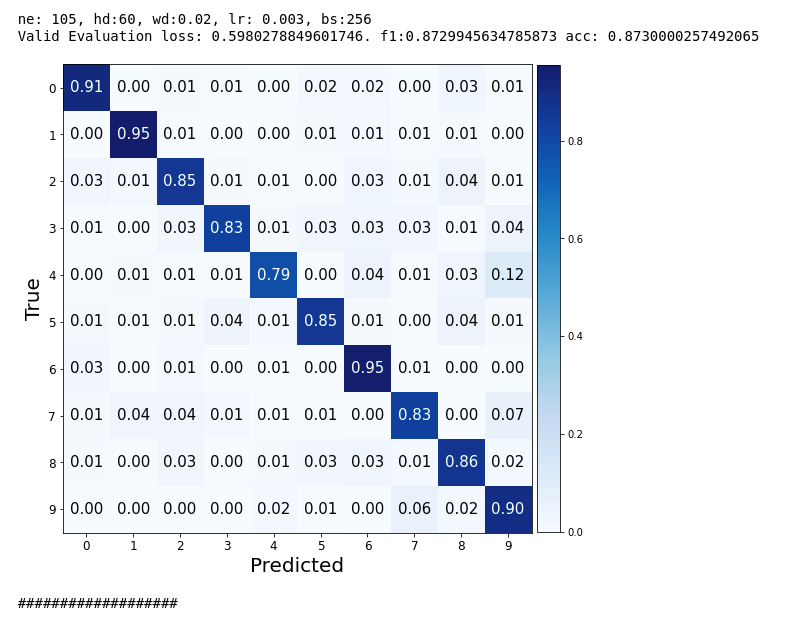

In [2]:
from IPython.display import Image
Image('./Modelos/Modelo 1.png')

# Modelo 2

In [ ]:
bs_list = [256,512,1024]
lr_list = [0.00001,0.0001,0.1]
wd_list = [0.00001,0.0001,0.1]
hd_list = [60,90,110]
ne_list = [25,65,120]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
    for bs in bs_list:
        train_ds = TensorDataset(X_train, Y_train)
        train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

        for lr in lr_list:
            for wd in wd_list:
                for hd in hd_list:
                    input_dim = 28*28
                    out_dim = 10
                    hidden = hd

                    model = torch.nn.Sequential(
                        torch.nn.Linear(input_dim, hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(hidden, out_dim)
                    )

                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    criterion = torch.nn.CrossEntropyLoss()

                    print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
                    train_valid(model,ne,optimizer,criterion)
                    print('###################\n')

                    pbar.update()
pbar.close()

ne: 25, hd:60, wd:1e-05, lr: 1e-05, bs:256 
###################

ne: 25, hd:90, wd:1e-05, lr: 1e-05, bs:256 
###################

ne: 25, hd:110, wd:1e-05, lr: 1e-05, bs:256 
###################

ne: 25, hd:60, wd:0.0001, lr: 1e-05, bs:256 
###################

ne: 25, hd:90, wd:0.0001, lr: 1e-05, bs:256 
###################

ne: 25, hd:110, wd:0.0001, lr: 1e-05, bs:256 
###################

ne: 25, hd:60, wd:0.1, lr: 1e-05, bs:256 
###################

ne: 25, hd:90, wd:0.1, lr: 1e-05, bs:256 
###################

ne: 25, hd:110, wd:0.1, lr: 1e-05, bs:256 
###################

ne: 25, hd:60, wd:1e-05, lr: 0.0001, bs:256 
###################

ne: 25, hd:90, wd:1e-05, lr: 0.0001, bs:256 
###################

ne: 25, hd:110, wd:1e-05, lr: 0.0001, bs:256 
###################

ne: 25, hd:60, wd:0.0001, lr: 0.0001, bs:256 
###################

ne: 25, hd:90, wd:0.0001, lr: 0.0001, bs:256 
###################

ne: 25, hd:110, wd:0.0001, lr: 0.0001, bs:256 
###################

ne: 25, hd:60,

###################

ne: 65, hd:90, wd:1e-05, lr: 0.1, bs:512 
###################

ne: 65, hd:110, wd:1e-05, lr: 0.1, bs:512 
###################

ne: 65, hd:60, wd:0.0001, lr: 0.1, bs:512 
###################

ne: 65, hd:90, wd:0.0001, lr: 0.1, bs:512 
###################

ne: 65, hd:110, wd:0.0001, lr: 0.1, bs:512 
###################

ne: 65, hd:60, wd:0.1, lr: 0.1, bs:512 
###################

ne: 65, hd:90, wd:0.1, lr: 0.1, bs:512 
###################

ne: 65, hd:110, wd:0.1, lr: 0.1, bs:512 
###################

ne: 65, hd:60, wd:1e-05, lr: 1e-05, bs:1024 
###################

ne: 65, hd:90, wd:1e-05, lr: 1e-05, bs:1024 
###################

ne: 65, hd:110, wd:1e-05, lr: 1e-05, bs:1024 
###################

ne: 65, hd:60, wd:0.0001, lr: 1e-05, bs:1024 
###################

ne: 65, hd:90, wd:0.0001, lr: 1e-05, bs:1024 
###################

ne: 65, hd:110, wd:0.0001, lr: 1e-05, bs:1024 
###################

ne: 65, hd:60, wd:0.1, lr: 1e-05, bs:1024 
###################

ne: 65, hd

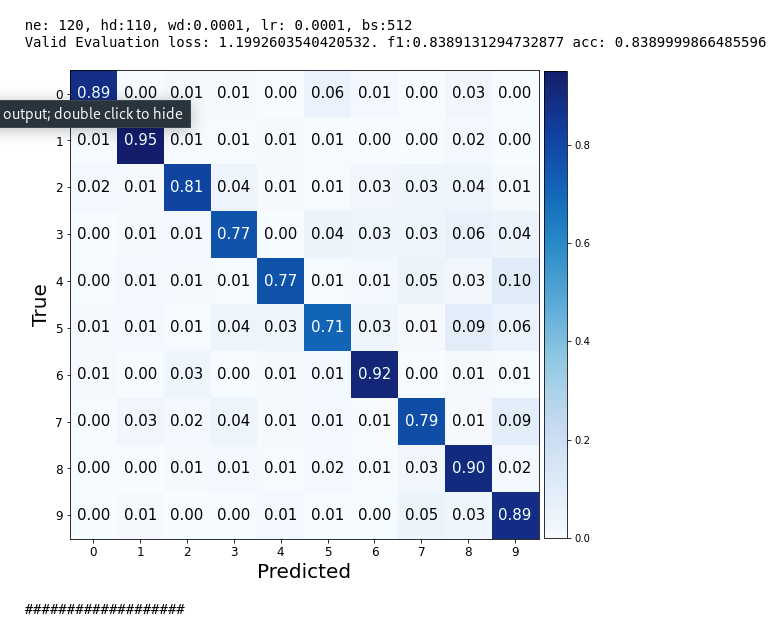

In [5]:
Image('./Modelos/Modelo 2.png')

## Análisis y Conclusión

De las iteraciones del $\textbf{modelo 1}$ escogemos un modelo con los parámetros $\textit{batch size (bs=256), learn rate (lr=0.003), weight decay (wd=0.02), número de neuronas (hd=60) y número de épocas (ne=105)}$ para los cuales se obtuvieron valores de los scores $\textbf{loss=0.60, f1_score=0.87}$ y $\textbf{accuracy=0.87}$, de forma que el para este modelo observamos una precisión bastante alta.

Para el $\textbf{modelo 2}$ escogemos la iteración con los siguiente resultados: $\textit{bs=512}, \textit{lr=0.0001}, \textit{wd=0.0001}, \textit{110}$ y $\textit{ne=120}$. Para estos los valores de los scores obtenidos son $\textbf{loss=1.20}, \textbf{f1_score=0.84}$ y $\textit{accuracy=0.84}$, por lo que se puede afirmar que la precisión del modelo es relativamente alta, aunque comparada con el modelo 1 no es muy precisa y en general los scores del modelo 1 son mejores que los del modelo 2.